Скачайте материалы к занятию. Проанализируйте ряды, сделайте их стационарными.

Решением будет ссылка на гитхаб с ноутбуком.

In [1]:

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

# Отображение графика

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

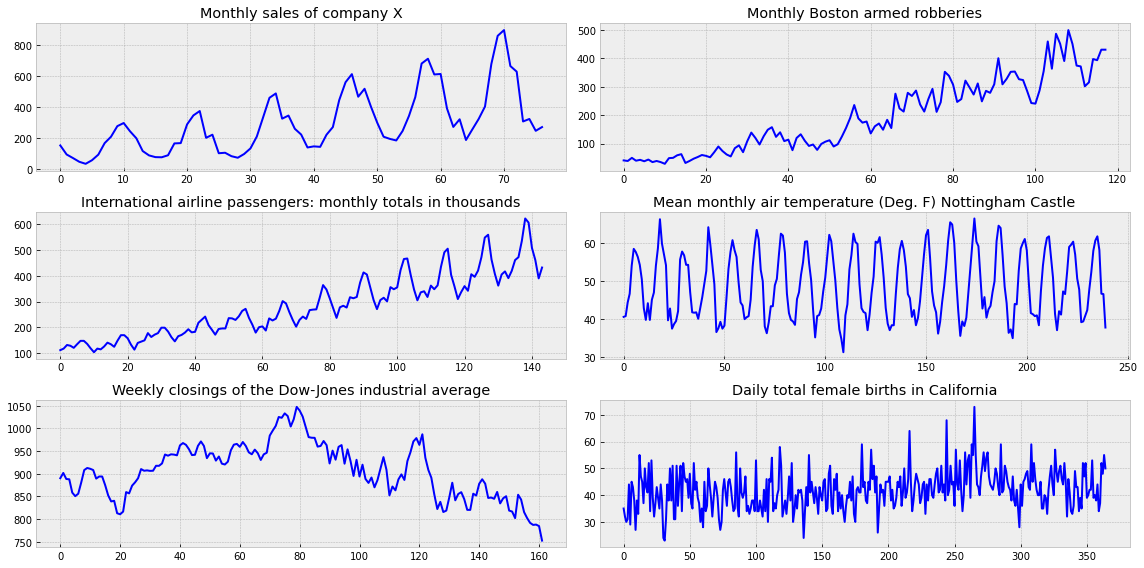

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()
    

# Ищем сезонность

In [6]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

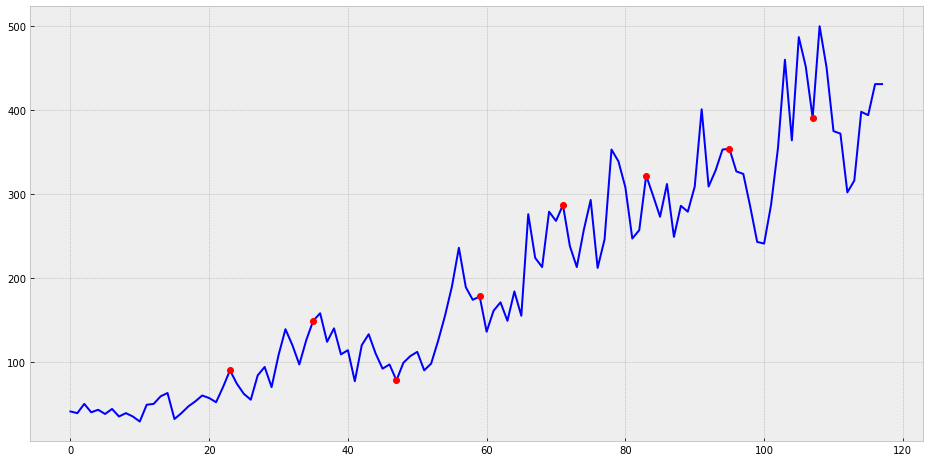

In [7]:
plot_ts_and_points(robberies_in_boston['Count'], 23, 12)

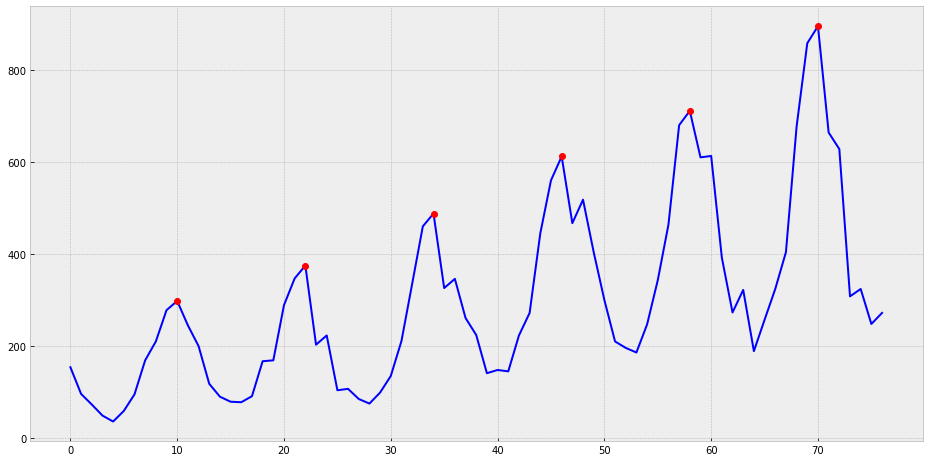

In [8]:
plot_ts_and_points(sales_of_company_x["Count"], 10, 12)

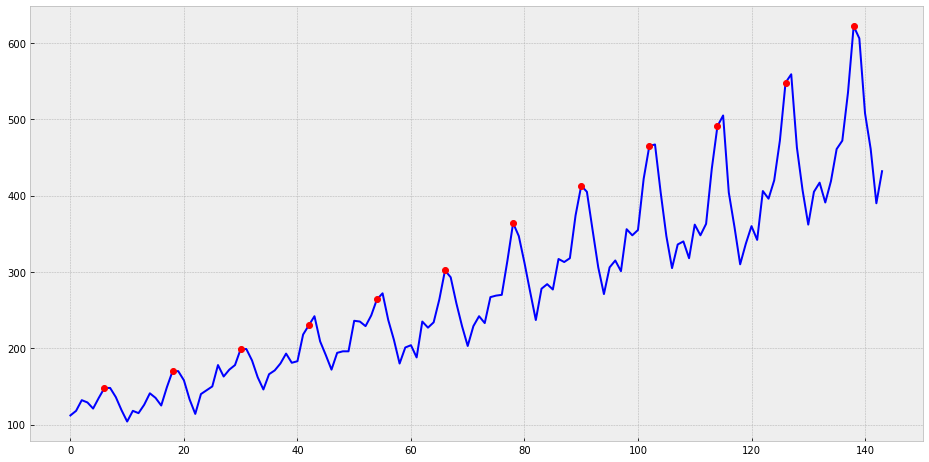

In [9]:
plot_ts_and_points(airlines_passengers["Count"], 6, 12)

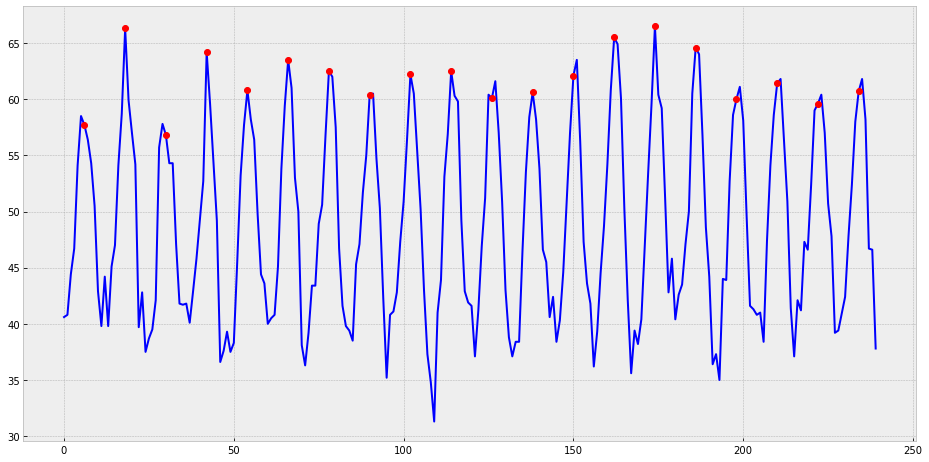

In [10]:
plot_ts_and_points( mean_monthly_temp["Deg"], 6, 12)    

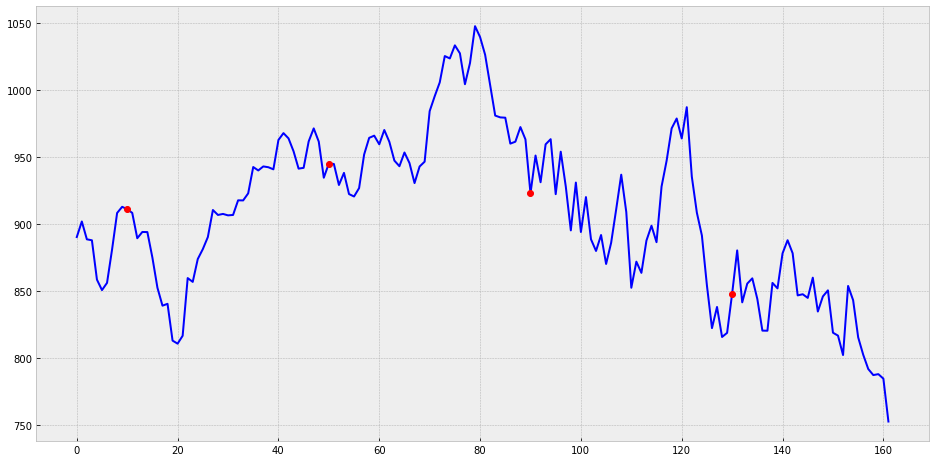

In [11]:
plot_ts_and_points( dowjones_closing["Close"], 10,40) 

сезонности нет в этом ряду

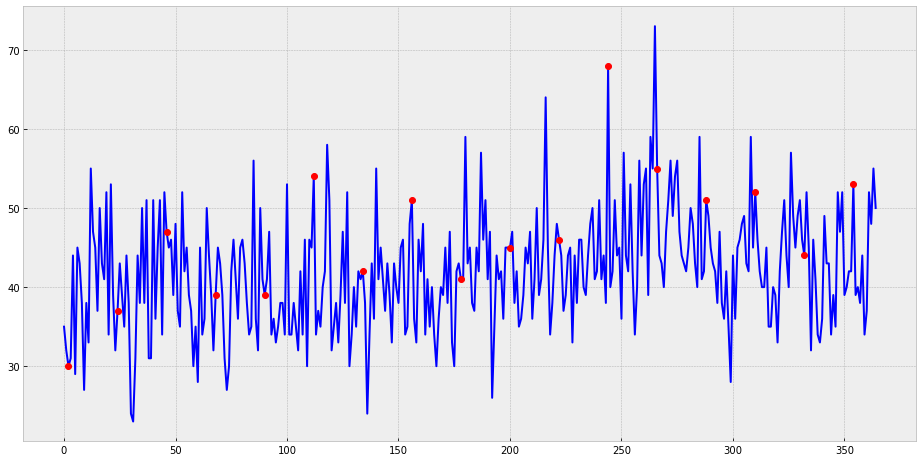

In [12]:
plot_ts_and_points( female_births["Count"], 2,22)

сезонности нет , стационарный ряд

# Нормализуем дисперсию

# Тест Дики-Фуллера

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [25]:
series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")['Count']

In [26]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


# Коррелограммы

In [27]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [28]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

C:\Users\ddns\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


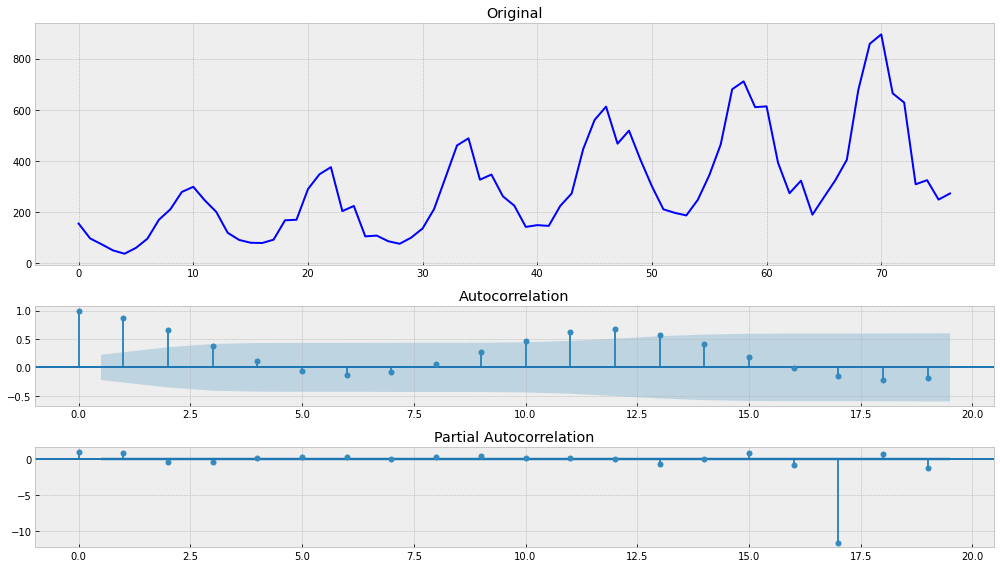

In [29]:
tsplot(series)

Как мы видим, и тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [32]:
series = boxcox(series, 0)

In [34]:

test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                 -1.535396
p-value                         0.515934
#Lags Used                     10.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64


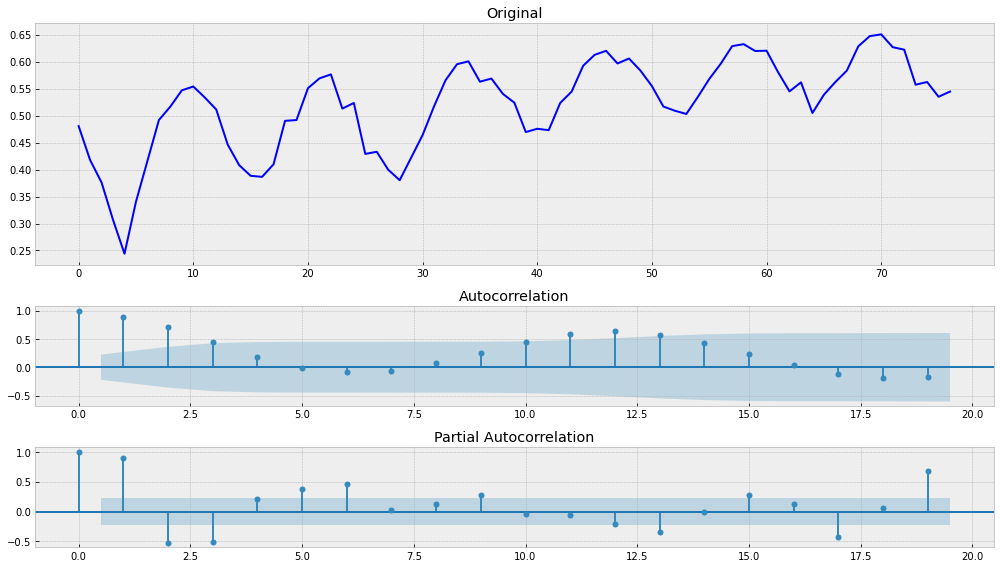

In [35]:
tsplot(series)

Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.

In [37]:
series = series[1:] - series[:-1]

In [38]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -7.394800e+00
p-value                        7.829156e-11
#Lags Used                     1.100000e+01
Number of Observations Used    6.300000e+01
Critical Value (1%)           -3.538695e+00
Critical Value (5%)           -2.908645e+00
Critical Value (10%)          -2.591897e+00
dtype: float64


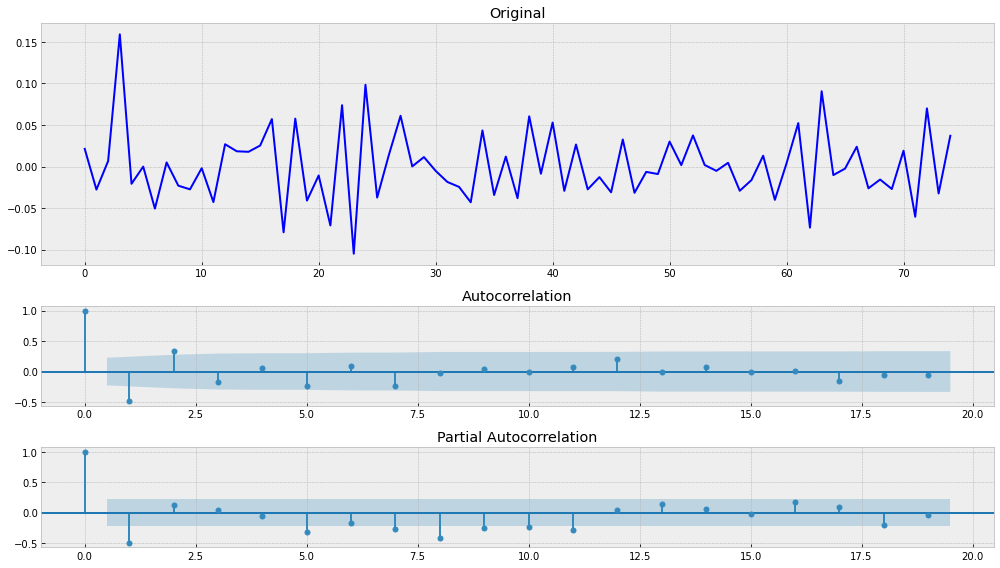

In [39]:
tsplot(series)

Стало еще лучше, но по графику коррелограммы видно сильное влияние сезонности. Уберем ее

In [40]:
series = series[12:] - series[:-12]

In [41]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                 -5.355117
p-value                         0.000004
#Lags Used                      9.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


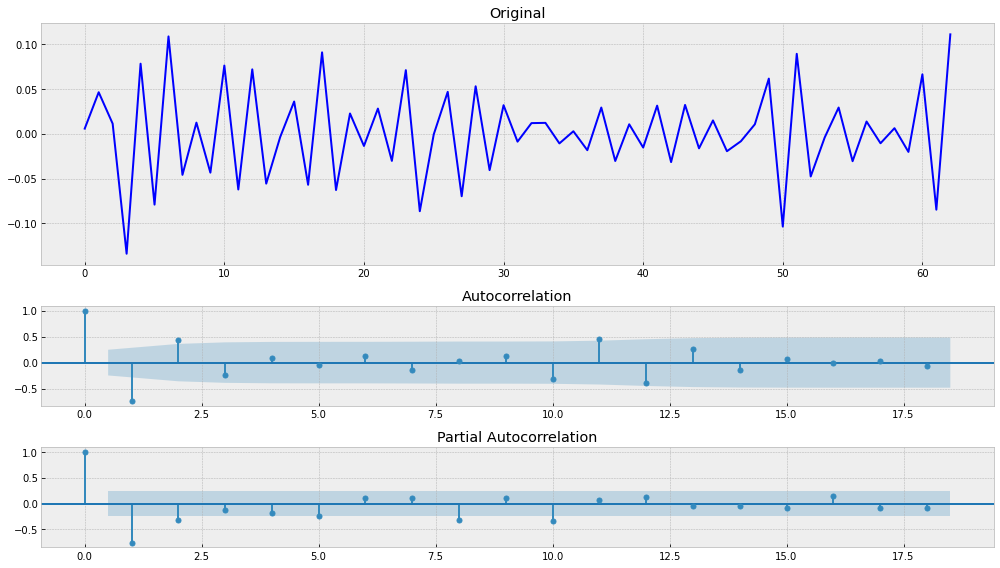

In [42]:
tsplot(series)

Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!